Mount drive to load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


import required packages

In [ ]:
import os
import cv2
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision.transforms import ToTensor
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters 
num_epochs = 4
batch_size = 4
learning_rate = 0.01

In [ ]:
def load_dataset(directory_path):
  image_transforms = transforms.Compose(
                    [transforms.Resize((32,32)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  return dataset

directory_path_female = "/content/drive/My Drive/dataset_female"
directory_path_male = "/content/drive/My Drive/dataset_male"
dataset_female = load_dataset(directory_path_female)
dataset_male = load_dataset(directory_path_male)

In [ ]:
#verify classes extracted from dataset
classes_female = dataset_female.classes
print(classes_female)
classes_male = dataset_male.classes
print(classes_male)

['not_a_person', 'with_mask', 'without_mask']
['not_a_person', 'with_mask', 'without_mask']


In [ ]:
#split into training and testing datasets
train_size_f = int(0.8 * len(dataset_female))
test_size_f = (len(dataset_female) - train_size_f)
train_dataset_female, test_dataset_female = random_split(dataset_female, (train_size_f, test_size_f))

#import datasets as train_loader and test_loader using dataloader
train_loader_female = DataLoader(dataset=train_dataset_female, shuffle=True, batch_size= batch_size, num_workers=2)
test_loader_female = DataLoader(dataset=test_dataset_female,shuffle=False,batch_size= batch_size)

In [ ]:
#split into training and testing datasets
train_size_m = int(0.8 * len(dataset_male))
test_size_m = (len(dataset_male) - train_size_m)
train_dataset_male, test_dataset_male = random_split(dataset_male, (train_size_m, test_size_m))

#import datasets as train_loader and test_loader using dataloader
train_loader_male = DataLoader(dataset=train_dataset_male, shuffle=True, batch_size= batch_size, num_workers=2)
test_loader_male = DataLoader(dataset=test_dataset_male, shuffle=True,  batch_size= batch_size)

In [ ]:
#nn.Module - Base class for all neural network modules
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding =1 ),
            nn.Conv2d(in_channels = 32 , out_channels = 32, kernel_size = 3, padding =1 ),      
            nn.MaxPool2d(kernel_size=2, stride =2),    
            nn.Conv2d(in_channels = 32 , out_channels = 64, kernel_size = 3, padding =1 ),           
            nn.Conv2d(in_channels = 64 , out_channels = 64, kernel_size = 3, padding =1 ),
            nn.MaxPool2d(kernel_size=2, stride =2),                    
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*8*64,512),
            nn.Linear(512, 256),
            nn.Linear(256, 3)        
        )
    
    def forward(self, x):
        #conv layers
        x = self.conv_layer(x)
        #flatten
        x = x.view(x.size(0), -1)
        #fc layer
        x = self.fc_layer(x)
        return x
    

In [ ]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
#method to train the model
def train_model(train_loader):
  total_steps = len(train_loader)
  
  for epoch in range(num_epochs):
      total_train = 0
      correct_train = 0
      for i, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # accuracy
          _, predicted = torch.max(outputs, 1)
          total_train += labels.nelement() #no of pixels in batch
          correct_train += predicted.eq(labels.data).sum().item()
          train_accuracy = 100 * correct_train / total_train

          if (i+1) % 100 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}')

  print('Training complete')
  PATH = './cnn.pth'
  torch.save(model.state_dict(), PATH)


In [ ]:
#method to test the model
def test_model(test_loader, classes):
  with torch.no_grad():
      correct = 0
      total = 0
      correct_class = [0 for i in range(3)]
      total_class = [0 for i in range(3)]
      all_labels = []
      all_predicted = []
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          all_labels.append(labels)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          all_predicted.append(predicted)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          for i in range(batch_size):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  correct_class[label] += 1
              total_class[label] += 1
      acc = 100.0 * correct / total

      for i in range(3):
          acc = 100.0 * correct_class[i] / total_class[i]
          print(f'Accuracy of {classes[i]}: {round(acc,2)} %')
      
      return (all_labels,all_predicted) 

In [ ]:
#method to evaluate the model using classifictaion report
def evaluate_model(all_labels,all_predicted):
  np_arr1 = []
  for label in all_labels:
    np_arr1.append(label.cpu().detach().numpy())
  all_labels_np = np.asarray(np_arr1).ravel()

  np_arr2 = []
  for label in all_predicted:
    np_arr2.append(label.cpu().detach().numpy())
  all_predicted_np = np.asarray(np_arr2).ravel()
  print("Total Accuracy    : ", str(round(accuracy_score(all_labels_np,all_predicted_np)*100,2)), '%')
  target_names= ['not_a_person', 'with_mask', 'without_mask']
  all_scores = classification_report(all_labels_np, all_predicted_np, target_names=target_names)
  print(all_scores)
  return (all_labels_np,all_predicted_np)

  

In [ ]:
#method to print confusion matrix
def printConfusionMatrix(all_labels_np,all_predicted_np):
  cf_matrix = confusion_matrix(all_labels_np,all_predicted_np)
  sns.heatmap(cf_matrix, annot=True, cmap='rocket_r', xticklabels=classes_female, yticklabels=classes_female, fmt='d')
  plt.title('Confusion Matrix')


Epoch [1/4], Step [100/487], Loss: 0.4279, Accuracy: 98.0000
Epoch [1/4], Step [200/487], Loss: 0.0098, Accuracy: 98.3750
Epoch [1/4], Step [300/487], Loss: 0.0006, Accuracy: 98.4167
Epoch [1/4], Step [400/487], Loss: 0.0005, Accuracy: 98.4375
Epoch [2/4], Step [100/487], Loss: 0.0029, Accuracy: 99.2500
Epoch [2/4], Step [200/487], Loss: 0.1301, Accuracy: 99.0000
Epoch [2/4], Step [300/487], Loss: 0.0002, Accuracy: 98.9167
Epoch [2/4], Step [400/487], Loss: 0.0000, Accuracy: 98.8750
Epoch [3/4], Step [100/487], Loss: 0.0000, Accuracy: 99.2500
Epoch [3/4], Step [200/487], Loss: 0.0001, Accuracy: 98.3750
Epoch [3/4], Step [300/487], Loss: 0.0325, Accuracy: 97.4167
Epoch [3/4], Step [400/487], Loss: 0.0064, Accuracy: 97.5625
Epoch [4/4], Step [100/487], Loss: 0.0001, Accuracy: 99.2500
Epoch [4/4], Step [200/487], Loss: 0.0406, Accuracy: 99.3750
Epoch [4/4], Step [300/487], Loss: 0.0000, Accuracy: 99.3333
Epoch [4/4], Step [400/487], Loss: 0.8750, Accuracy: 98.9375
Training complete
Accura

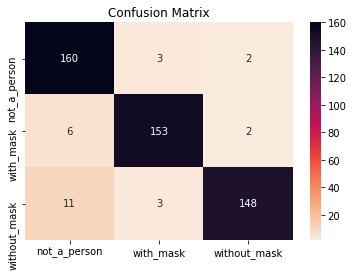

In [ ]:
#The training phase
train_model(train_loader_female)
#The testing phase
all_labels,all_predicted = test_model(test_loader_female, classes_female)

#The evaluation phase
all_labels_np,all_predicted_np = evaluate_model(all_labels,all_predicted)
#confusion matrix
printConfusionMatrix(all_labels_np,all_predicted_np)

Epoch [1/4], Step [100/487], Loss: 0.0337, Accuracy: 94.7500
Epoch [1/4], Step [200/487], Loss: 0.0102, Accuracy: 94.6250
Epoch [1/4], Step [300/487], Loss: 0.0488, Accuracy: 94.0000
Epoch [1/4], Step [400/487], Loss: 0.0312, Accuracy: 93.9375
Epoch [2/4], Step [100/487], Loss: 0.0040, Accuracy: 96.0000
Epoch [2/4], Step [200/487], Loss: 0.0407, Accuracy: 96.2500
Epoch [2/4], Step [300/487], Loss: 0.0871, Accuracy: 96.7500
Epoch [2/4], Step [400/487], Loss: 0.0368, Accuracy: 96.5000
Epoch [3/4], Step [100/487], Loss: 0.0028, Accuracy: 94.7500
Epoch [3/4], Step [200/487], Loss: 0.0022, Accuracy: 96.0000
Epoch [3/4], Step [300/487], Loss: 0.0073, Accuracy: 95.8333
Epoch [3/4], Step [400/487], Loss: 0.0066, Accuracy: 96.5000
Epoch [4/4], Step [100/487], Loss: 0.0043, Accuracy: 97.2500
Epoch [4/4], Step [200/487], Loss: 0.0002, Accuracy: 98.0000
Epoch [4/4], Step [300/487], Loss: 0.0001, Accuracy: 98.1667
Epoch [4/4], Step [400/487], Loss: 0.0063, Accuracy: 98.0000
Training complete
Accura

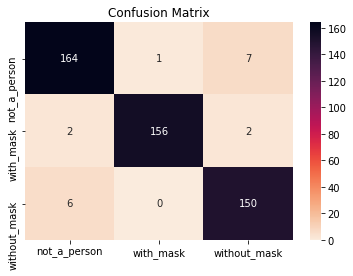

In [ ]:
#The training phase
train_model(train_loader_male)
#The testing phase
all_labels,all_predicted = test_model(test_loader_male, classes_male)
#The evaluation phase
all_labels_np,all_predicted_np = evaluate_model(all_labels,all_predicted)
#confusion matrix
printConfusionMatrix(all_labels_np,all_predicted_np)

K-Fold

In [ ]:
def apply_kfold(dataset,train_loader,test_loader, classes):
  k_folds = 10
  kfold = KFold(n_splits=k_folds, shuffle=True)
  # enumerate splits
  all_accuracy = []
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(dataset,batch_size=10, sampler=test_subsampler)
    print('pass',fold)
    train_model(train_loader)
    all_labels,all_predicted = test_model(test_loader, classes)
    all_labels_np,all_predicted_np = evaluate_model(all_labels,all_predicted)
    accuracy = accuracy_score(all_labels_np,all_predicted_np)* 100
    all_accuracy.append(accuracy)

  print('K fold accuracy :',str(round(sum(all_accuracy) / len(all_accuracy),2) ),'%')

In [ ]:
#female
apply_kfold(dataset_female, train_loader_female, test_loader_female, classes_female)

pass 0
Epoch [1/4], Step [100/487], Loss: 0.0009, Accuracy: 100.0000
Epoch [1/4], Step [200/487], Loss: 0.0005, Accuracy: 100.0000
Epoch [1/4], Step [300/487], Loss: 0.0008, Accuracy: 100.0000
Epoch [1/4], Step [400/487], Loss: 0.0011, Accuracy: 99.9375
Epoch [2/4], Step [100/487], Loss: 0.0000, Accuracy: 100.0000
Epoch [2/4], Step [200/487], Loss: 0.0000, Accuracy: 99.8750
Epoch [2/4], Step [300/487], Loss: 0.0000, Accuracy: 99.9167
Epoch [2/4], Step [400/487], Loss: 0.0034, Accuracy: 99.8750
Epoch [3/4], Step [100/487], Loss: 0.0000, Accuracy: 99.7500
Epoch [3/4], Step [200/487], Loss: 0.0000, Accuracy: 99.8750
Epoch [3/4], Step [300/487], Loss: 0.0057, Accuracy: 99.9167
Epoch [3/4], Step [400/487], Loss: 0.0000, Accuracy: 99.9375
Epoch [4/4], Step [100/487], Loss: 0.0000, Accuracy: 100.0000
Epoch [4/4], Step [200/487], Loss: 0.0001, Accuracy: 99.8750
Epoch [4/4], Step [300/487], Loss: 0.0000, Accuracy: 99.9167
Epoch [4/4], Step [400/487], Loss: 0.0007, Accuracy: 99.9375
Training com

In [ ]:
#male
apply_kfold(dataset_male, train_loader_male, test_loader_male, classes_male)

pass 0
Epoch [1/4], Step [100/487], Loss: 0.0160, Accuracy: 95.0000
Epoch [1/4], Step [200/487], Loss: 0.0849, Accuracy: 95.1250
Epoch [1/4], Step [300/487], Loss: 0.0706, Accuracy: 95.8333
Epoch [1/4], Step [400/487], Loss: 0.0073, Accuracy: 96.1250
Epoch [2/4], Step [100/487], Loss: 0.0942, Accuracy: 99.0000
Epoch [2/4], Step [200/487], Loss: 0.0000, Accuracy: 98.5000
Epoch [2/4], Step [300/487], Loss: 0.0018, Accuracy: 98.2500
Epoch [2/4], Step [400/487], Loss: 0.0085, Accuracy: 98.2500
Epoch [3/4], Step [100/487], Loss: 0.0011, Accuracy: 98.7500
Epoch [3/4], Step [200/487], Loss: 0.0000, Accuracy: 98.6250
Epoch [3/4], Step [300/487], Loss: 0.0000, Accuracy: 98.7500
Epoch [3/4], Step [400/487], Loss: 0.0002, Accuracy: 98.6250
Epoch [4/4], Step [100/487], Loss: 0.0000, Accuracy: 100.0000
Epoch [4/4], Step [200/487], Loss: 0.0000, Accuracy: 99.6250
Epoch [4/4], Step [300/487], Loss: 0.0000, Accuracy: 99.4167
Epoch [4/4], Step [400/487], Loss: 0.0027, Accuracy: 99.3750
Training complet